In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from importlib import reload
from ea_data_loader import load_ea_data
import math
import copy

%load_ext autoreload
%autoreload 2


tfd = tfp.distributions
tfb = tfp.bijectors
dtype = np.float32
plt.style.use('ggplot')

In [2]:
data = [load_ea_data(vid=v)[0] for v in [0, 1, 2, 3, 4, 5, 6, 7]]
m, q, _ = data[0].shape

print(data[0].shape)
print(data[1].shape)

(372, 400, 85)
(372, 400, 73)


In [3]:
from shared_gpfa import SharedGpfa

p = 20
model = SharedGpfa(m, q, p, reg=0.)
l = model.fit(train_data=data, n_iters=2000, learning_rate=0.06, tensorboard=False)

0%|          | 0/2000 [00:00<?, ?it/s]WARNING:tensorflow:From C:\Users\mamar\.conda\envs\tf\lib\site-packages\tensorflow_core\python\ops\linalg\linear_operator_lower_triangular.py:158: calling LinearOperator.__init__ (from tensorflow.python.ops.linalg.linear_operator) with graph_parents is deprecated and will be removed in a future version.
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
100%|██████████| 2000/2000 [06:31<00:00,  5.10it/s]


[<tfp.distributions.JointDistributionNamed 'JointDistributionNamed' batch_shape={obs: [], x: []} event_shape={obs: [372, 400, 85], x: [20, 85]} dtype={obs: float32, x: float32}>, <tfp.distributions.JointDistributionNamed 'JointDistributionNamed' batch_shape={obs: [], x: []} event_shape={obs: [372, 400, 73], x: [20, 73]} dtype={obs: float32, x: float32}>, <tfp.distributions.JointDistributionNamed 'JointDistributionNamed' batch_shape={obs: [], x: []} event_shape={obs: [372, 400, 55], x: [20, 55]} dtype={obs: float32, x: float32}>, <tfp.distributions.JointDistributionNamed 'JointDistributionNamed' batch_shape={obs: [], x: []} event_shape={obs: [372, 400, 72], x: [20, 72]} dtype={obs: float32, x: float32}>, <tfp.distributions.JointDistributionNamed 'JointDistributionNamed' batch_shape={obs: [], x: []} event_shape={obs: [372, 400, 68], x: [20, 68]} dtype={obs: float32, x: float32}>, <tfp.distributions.JointDistributionNamed 'JointDistributionNamed' batch_shape={obs: [], x: []} event_shape={

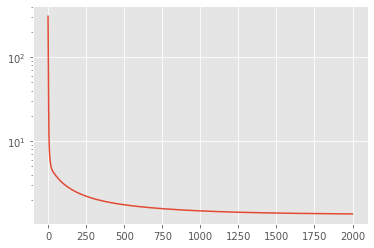

In [4]:
print(model.joint)
plt.style.use('ggplot')

plt.figure()
plt.plot(l)
plt.yscale('log')

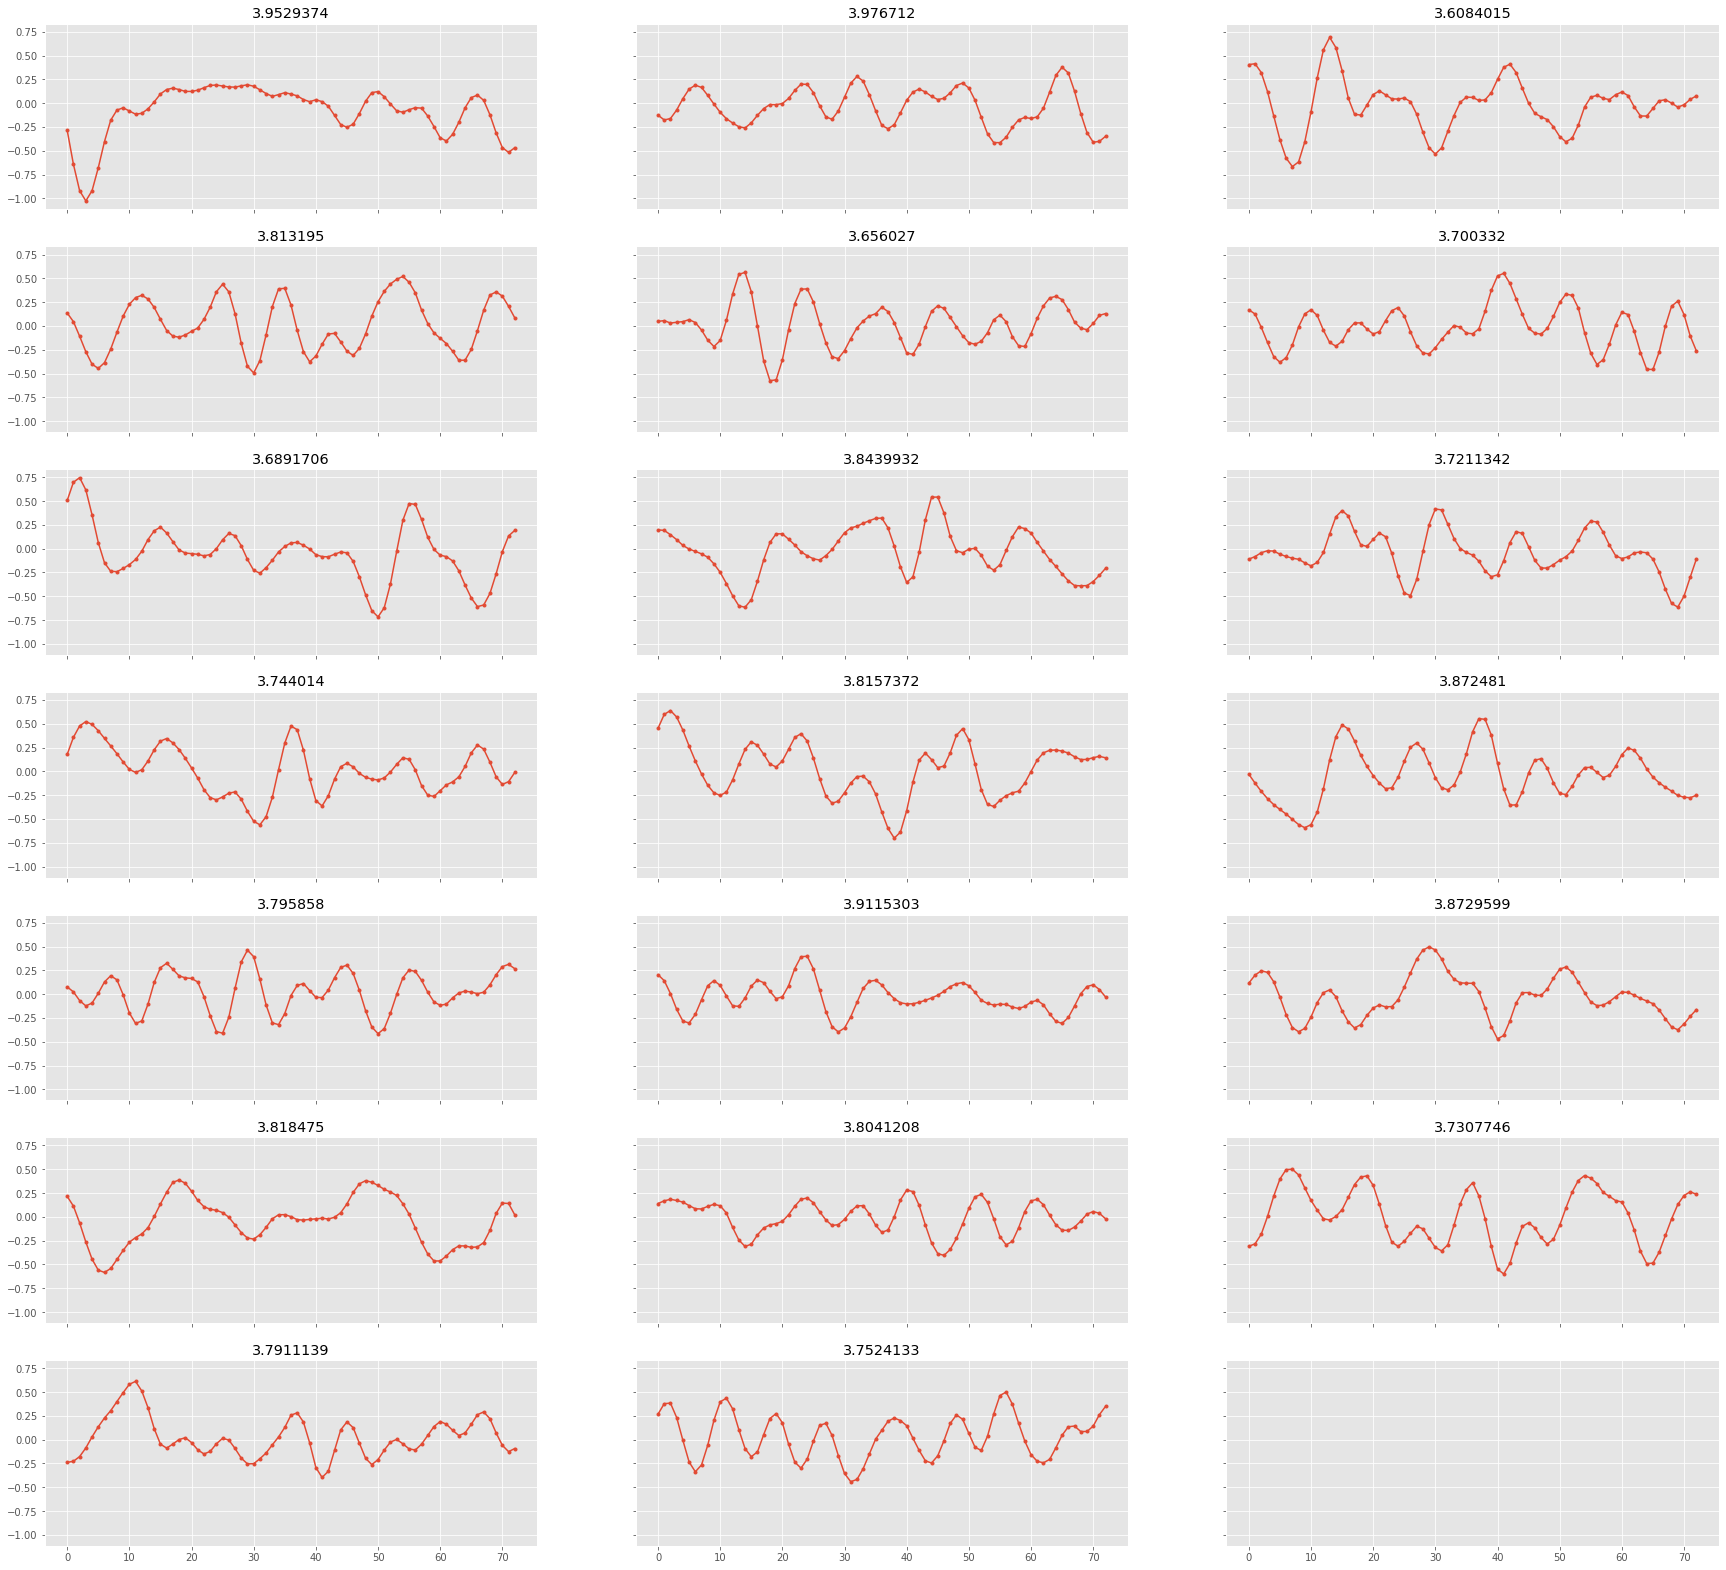

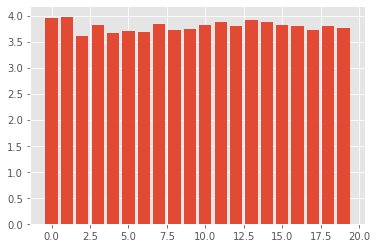

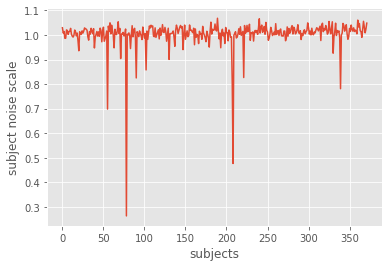

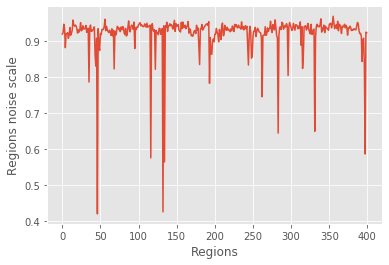

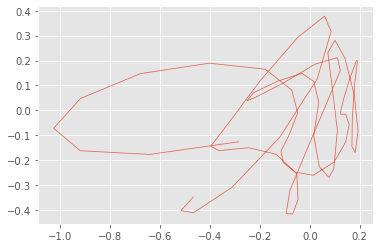

In [5]:
x = model.vars['x'][1].numpy()
xsample = model.joint[0].sample()['x'].numpy()
length_scale = tf.convert_to_tensor(model.vars['length_scale']).numpy()

n_rows = model.p//3 + 1
fig, axs = plt.subplots(n_rows, 3, figsize=(30, n_rows * 4), sharex=True, sharey=True)
for xx, xxs, l, ax in zip(x, xsample, length_scale, axs.flat):
    ax.plot(np.arange(x.shape[-1]), xx, marker='.')
    # ax.plot(np.arange(t), xxs, marker='.')
    ax.set_title(l)

plt.figure()
plt.bar(np.arange(model.p), length_scale)

plt.figure()
plt.plot(tf.convert_to_tensor(model.vars['subject_noise_scale']))
plt.xlabel('subjects')
plt.ylabel('subject noise scale')

plt.figure()
plt.plot(tf.convert_to_tensor(model.vars['roi_noise_scale']))
plt.xlabel('Regions')
plt.ylabel('Regions noise scale')

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(*x[0:2], lw=0.8, alpha=0.8)
ax.set_aspect('equal', 'box')


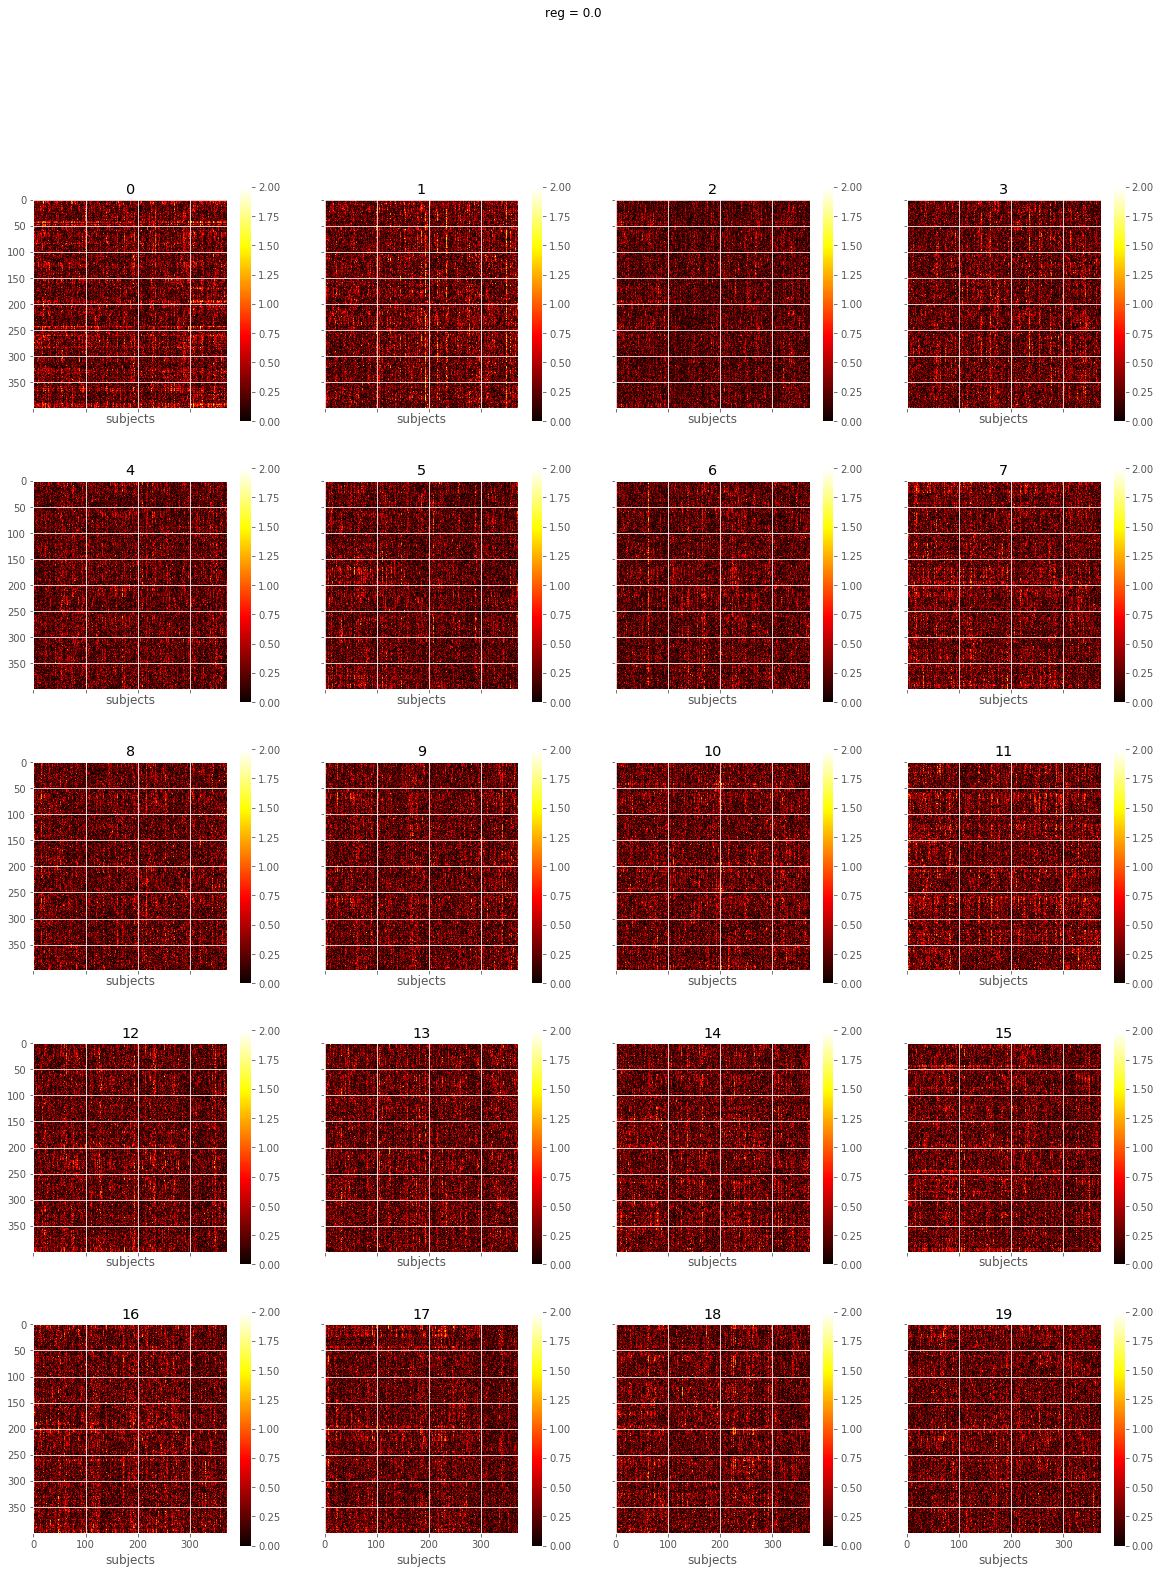

In [6]:
ncols = 4
nrows = math.ceil(p / 4)
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*5), sharex=True, sharey=True)
fig.suptitle(f'reg = {model.reg}')
vmax = tf.reduce_max(model.vars['w'])
for w, ax, comp in zip(model.vars['w'].numpy().transpose((2,1,0)), axs.flat, np.arange(p)):
    im = ax.imshow(np.abs(w), cmap='hot', vmin=0, vmax=vmax)
    ax.set_title(comp)
    fig.colorbar(im, ax=ax)
    ax.set_xlabel('subjects')

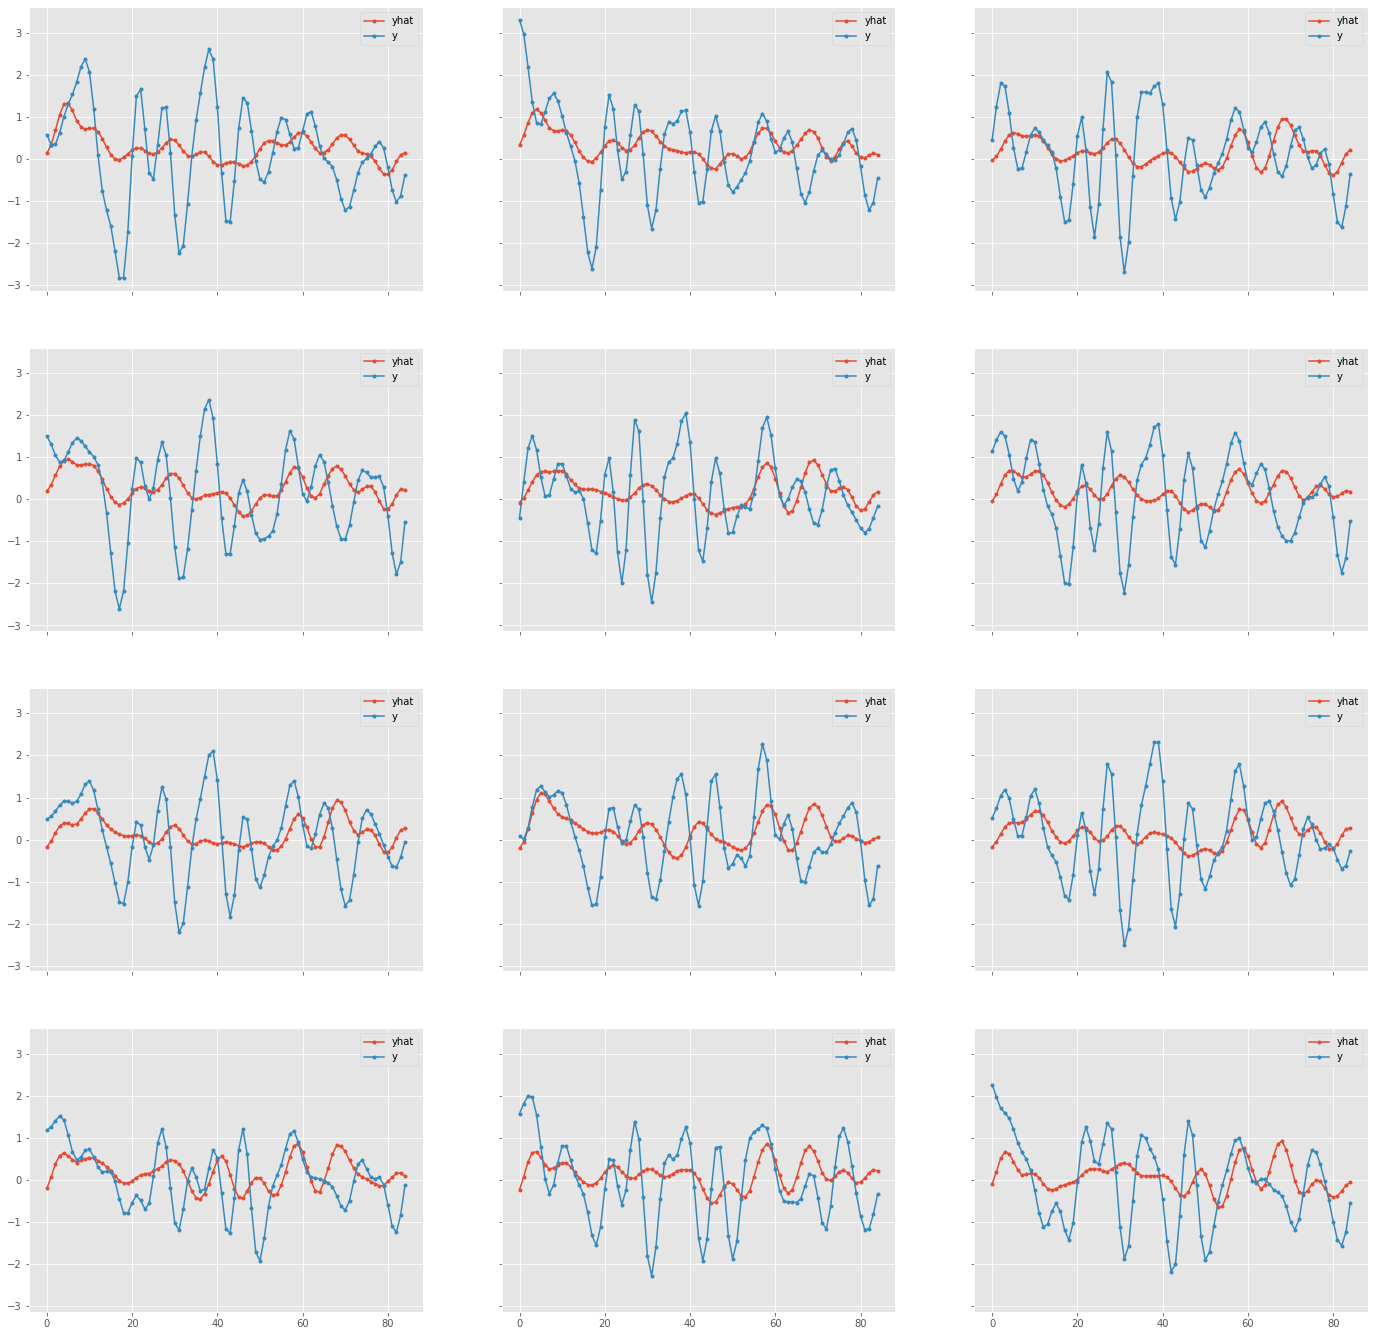

In [7]:
y_hat = model.vars['w'].numpy() @ model.vars['x'][0].numpy()
y = data[0]

n_rows = 4
n_cols = 3
sub = 198

fig, axs = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows), sharex=True, sharey=True)
for _y_hat, _y, ax in zip(y_hat[sub], y[sub], axs.flat):
    ax.plot(np.arange(y.shape[-1]), _y_hat, marker='.', label='yhat')
    ax.plot(np.arange(y.shape[-1]), _y, marker='.', label='y')
    ax.legend()

In [8]:
# w, l = model.add_subject(data[0:10], 0)
# print(l)

100%|██████████| 2000/2000 [00:26<00:00, 75.60it/s]


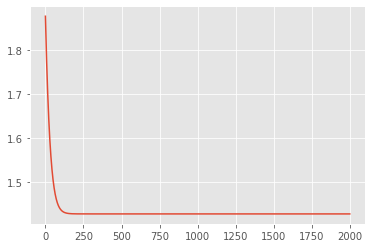

In [9]:
from shared_gpfa import SharedGpfa

valid = load_ea_data(vid=8)[0]

xlist, l = model.add_video(valid, n_iters=2000, learning_rate=0.01)
# xlist, l = model.add_video(data[1], n_iters=2000, learning_rate=0.01)

plt.plot(l)
# plt.yscale('log')

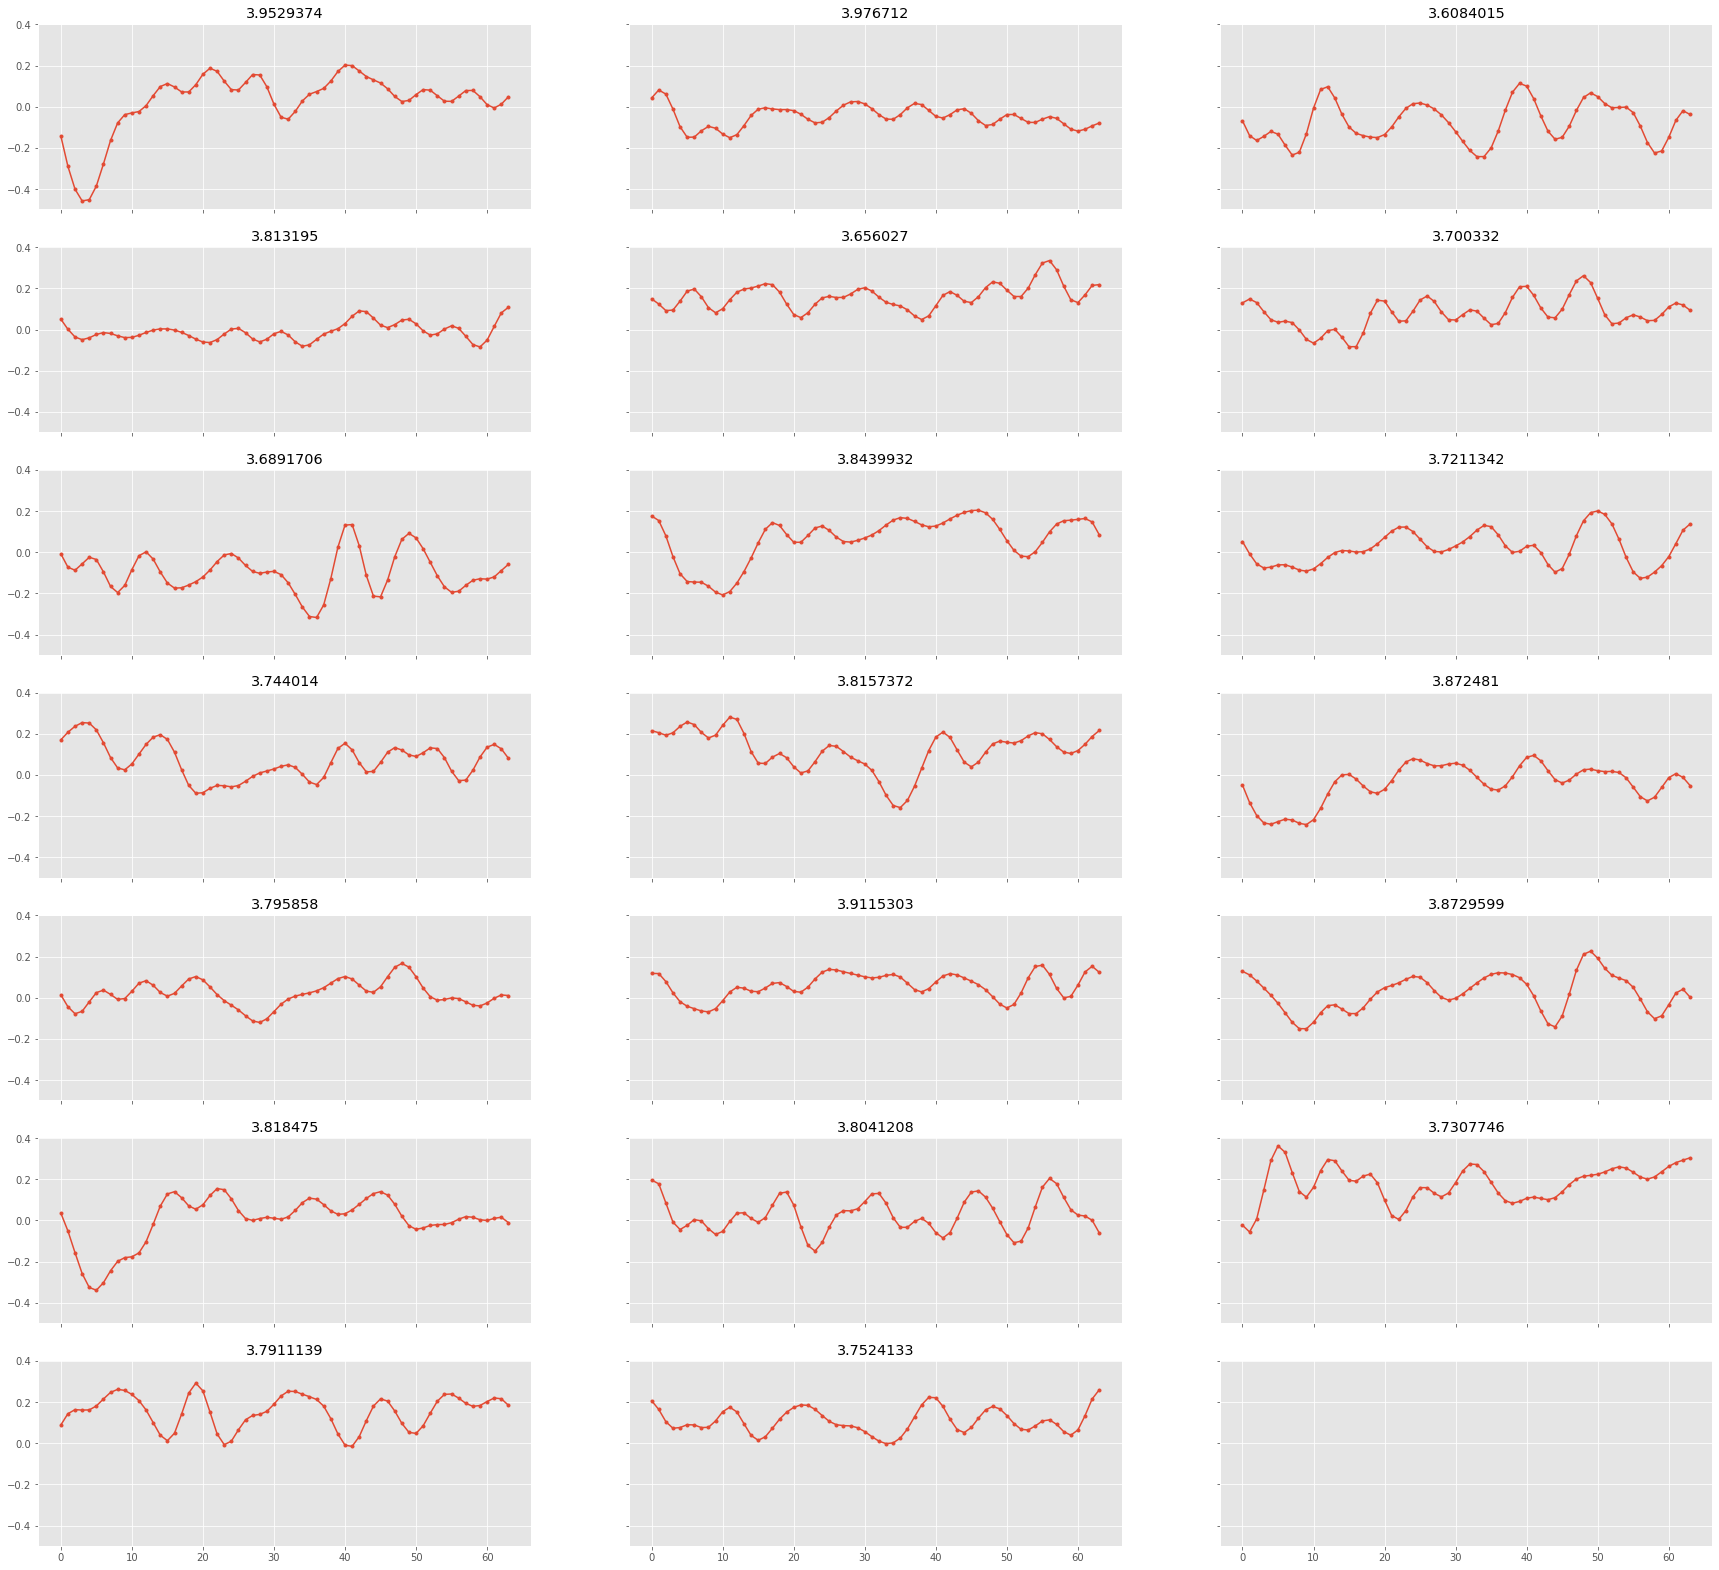

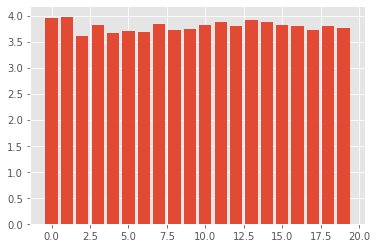

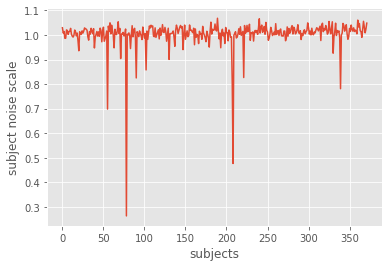

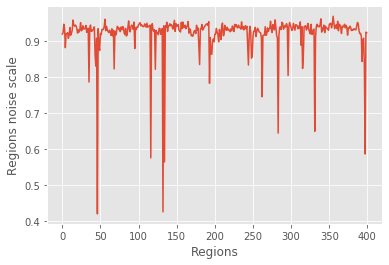

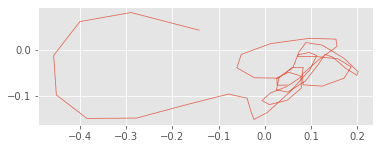

In [10]:
length_scale = tf.convert_to_tensor(model.vars['length_scale']).numpy()
x = xlist[0].numpy()
n_rows = model.p//3 + 1
fig, axs = plt.subplots(n_rows, 3, figsize=(30, n_rows * 4), sharex=True, sharey=True)
for xx, l, ax in zip(x, length_scale, axs.flat):
    ax.plot(np.arange(x.shape[-1]), xx, marker='.')
    ax.set_title(l)

plt.figure()
plt.bar(np.arange(model.p), length_scale)

plt.figure()
plt.plot(tf.convert_to_tensor(model.vars['subject_noise_scale']))
plt.xlabel('subjects')
plt.ylabel('subject noise scale')

plt.figure()
plt.plot(tf.convert_to_tensor(model.vars['roi_noise_scale']))
plt.xlabel('Regions')
plt.ylabel('Regions noise scale')

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(*x[0:2], lw=0.8, alpha=0.8)
ax.set_aspect('equal', 'box')

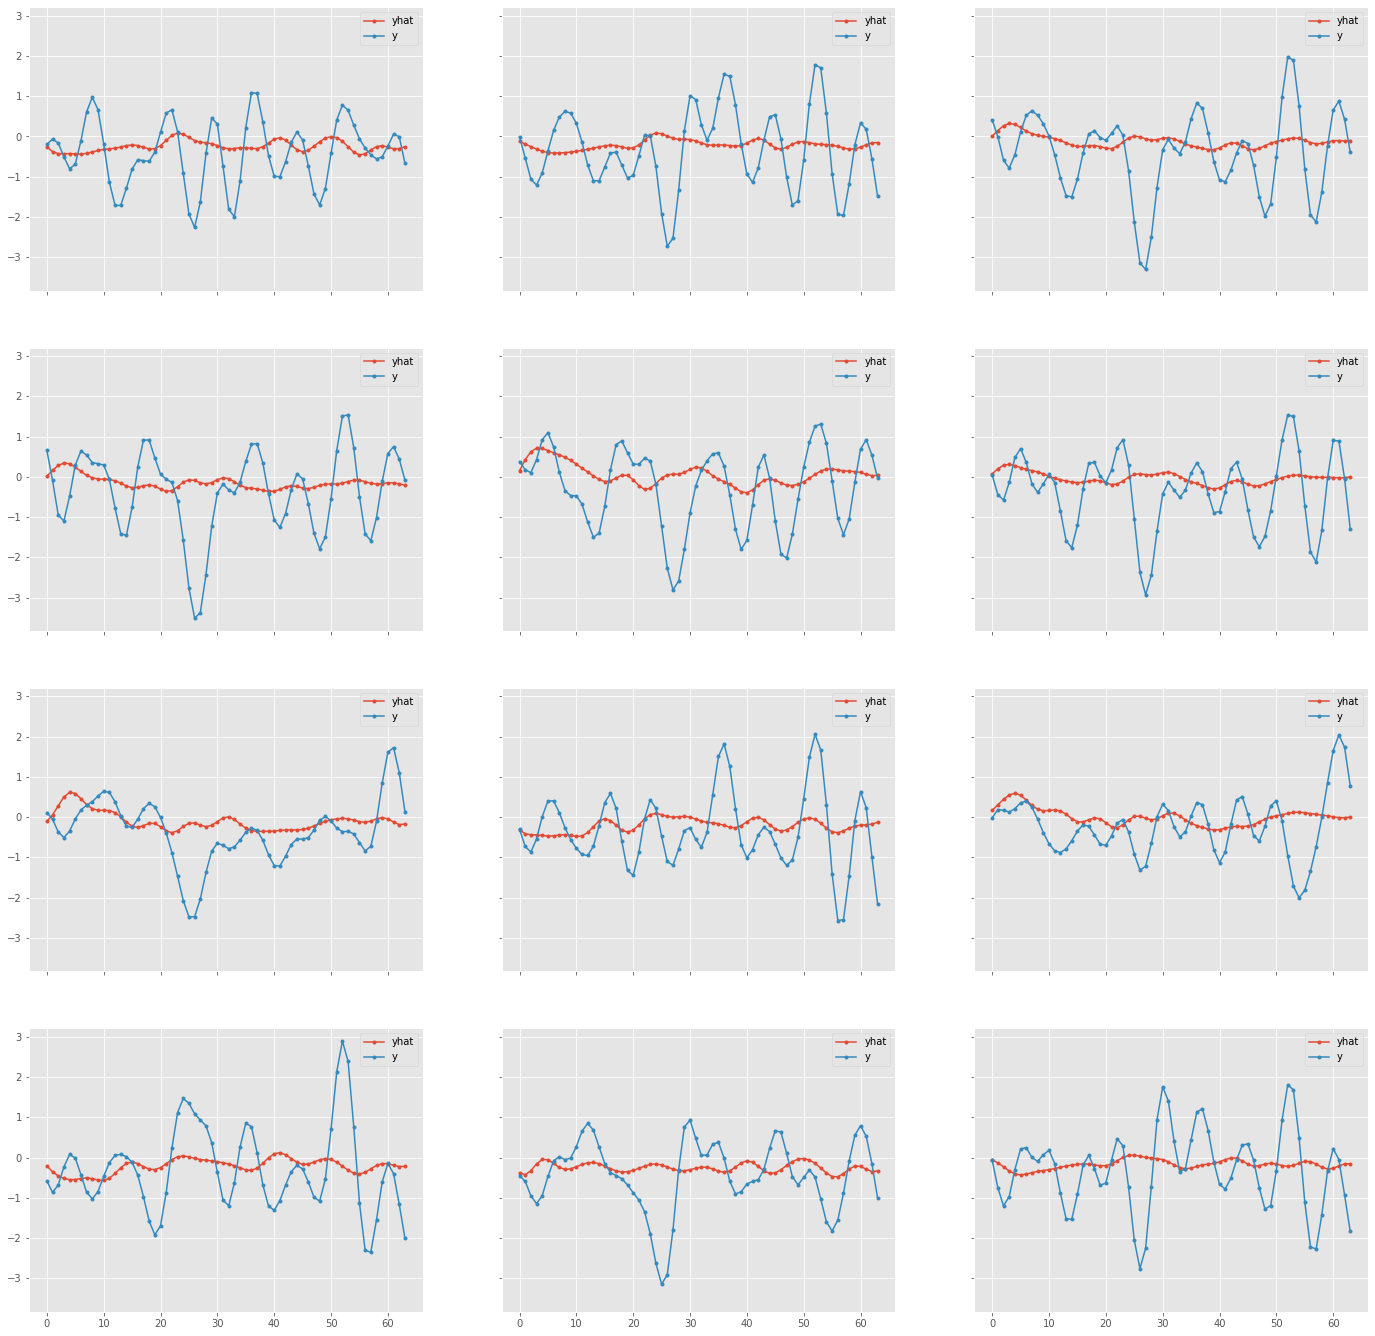

In [11]:
y_hat = model.vars['w'].numpy() @ xlist[0]

n_rows = 4
n_cols = 3
sub = 11

fig, axs = plt.subplots(n_rows, n_cols, figsize=(8*n_cols, 6*n_rows), sharex=True, sharey=True)
for _y_hat, _y, ax in zip(y_hat[sub], valid[sub], axs.flat):
    ax.plot(_y_hat, marker='.', label='yhat')
    ax.plot(_y, marker='.', label='y')
    ax.legend()

In [12]:
n_rows = 4
n_cols = 3

fig, axs = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows), sharex=True, sharey=True)

for d, ax in zip(np.transpose(data[0][:10], (1, 0, 2)), axs.flat):
    ax.plot(np.arange(data.shape[-1]), d.T, marker='.')


ValueError: could not broadcast input array from shape (372,400,85) into shape (372,400)